In [1]:
import os
from math import *

from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import rioxarray as rxr
import geopandas as gpd
import rasterstats as rs
import earthpy as et

In [2]:
sns.set_style("white")
sns.set(font_scale=1.5)

In [3]:
data = et.data.get_data("spatial-vector-lidar")
os.chdir(os.path.join(et.io.HOME,'earth-analytics','data'))

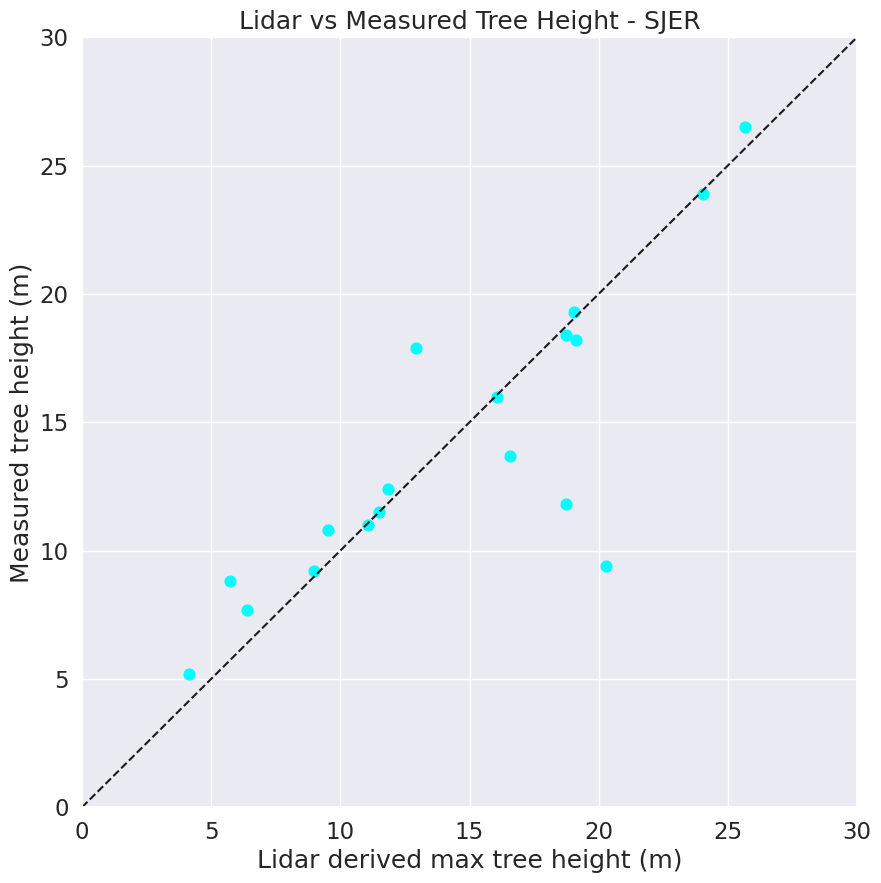

In [4]:
lidar_path = os.path.join("spatial-vector-lidar",
                          "california",
                          "neon-sjer-site",
                          "2013",
                          "lidar",
                          "SJER_lidarCHM.tif")

sjer_chm_data = rxr.open_rasterio(lidar_path, masked=True).squeeze()

plot_buffer_path = os.path.join("spatial-vector-lidar",
                                "outputs",
                                "plot_buffer.shp")

sjer_tree_heights = rs.zonal_stats(plot_buffer_path,
                                   sjer_chm_data.values,
                                   affine=sjer_chm_data.rio.transform(),
                                   geojson_out=True,
                                   copy_properties=True,
                                   nodata=0,
                                   stats="mean max")

sjer_lidar_height_df = gpd.GeoDataFrame.from_features(sjer_tree_heights)

path_insitu = os.path.join("spatial-vector-lidar",
                           "california",
                           "neon-sjer-site",
                           "2013",
                           "insitu",
                           "veg_structure",
                           "D17_2013_SJER_vegStr.csv")

sjer_insitu = pd.read_csv(path_insitu)

insitu_stem_ht = sjer_insitu.groupby('plotid', as_index=False)
insitu_stem_ht = insitu_stem_ht['stemheight'].agg(['max', 'mean'])
insitu_stem_ht = insitu_stem_ht.rename(
    columns={'max': 'insitu_maxht', 'mean': 'insitu_meanht'})
insitu_stem_ht.reset_index(inplace=True)

sjer_lidar_height_df = sjer_lidar_height_df.rename(
    columns={'max': 'lidar_max',
             'mean': 'lidar_mean',
             'min': 'lidar_min'})

sjer_final_height = sjer_lidar_height_df.merge(insitu_stem_ht,
                                               left_on='Plot_ID',
                                               right_on='plotid')

sjer_final_height_df = pd.DataFrame(sjer_final_height)


fig, ax = plt.subplots(figsize=(10, 10))


sjer_final_height_df.plot('lidar_max', 'insitu_maxht',
                          kind='scatter', color="aqua",
                          s=60, ax=ax)

ax.set(xlim=[0, 30], ylim=[0, 30], label="Data")
ax.plot((0, 1), (0, 1), transform=ax.transAxes, ls='--',
        c='k', label="1:1 line")

ax.set(xlabel="Lidar derived max tree height (m)",
       ylabel="Measured tree height (m)", title="Lidar vs Measured Tree Height - SJER")

plt.show()

In [5]:
x = sjer_final_height_df.lidar_max
y = sjer_final_height_df.insitu_maxht

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

print("slope:", slope,
      "\nintercept:", intercept,
      "\nr squared:", r_value**2)

slope: 0.7607314439776315 
intercept: 2.98146647443445 
r squared: 0.6910551716430489


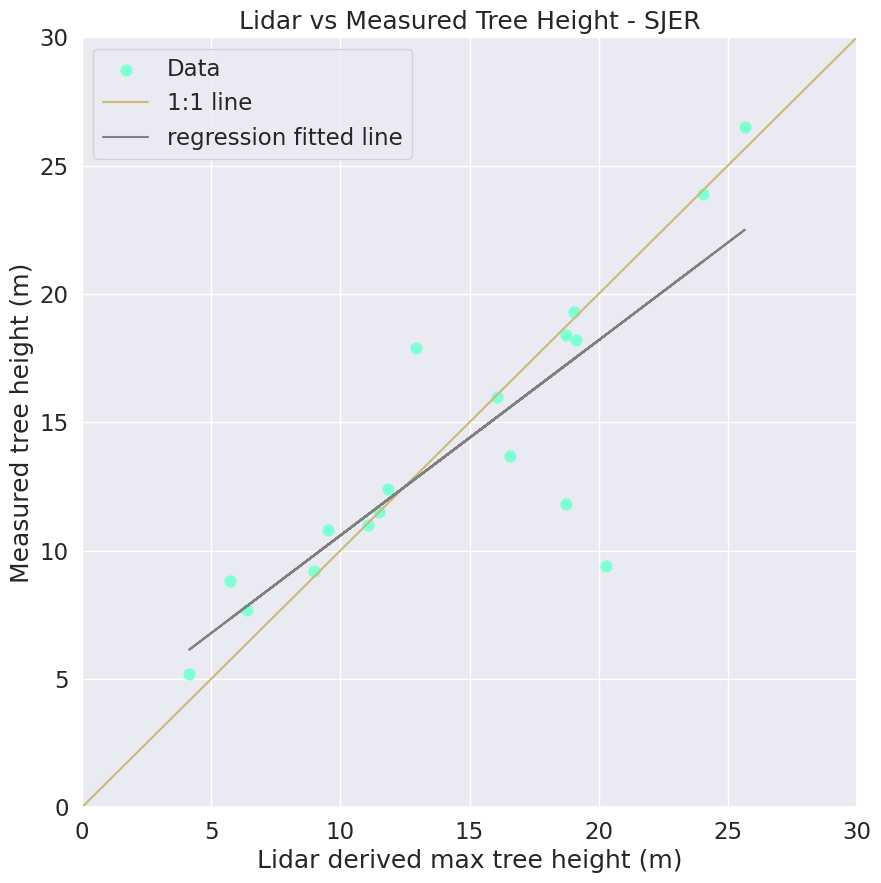

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))

m = slope.astype(float)

sjer_final_height_df.plot('lidar_max',
                          'insitu_maxht',
                          kind='scatter',
                          color="aquamarine",
                          s=60,
                          ax=ax,
                          label="Data")

ax.set(xlim=[0, 30], ylim=[0, 30])
ax.plot((0, 1), (0, 1), 'y-', transform=ax.transAxes, label="1:1 line")
ax.plot(x, m*x + intercept, 'grey', label='regression fitted line')

ax.set(xlabel="Lidar derived max tree height (m)",
       ylabel="Measured tree height (m)",
       title="Lidar vs Measured Tree Height - SJER")

plt.legend()
plt.show()

slope: 1.0 
intercept: 10.0 
r squared: 1.0 
p-value: 1.9206748078018256e-50 
st_error 0.0 
RMSE 0.0


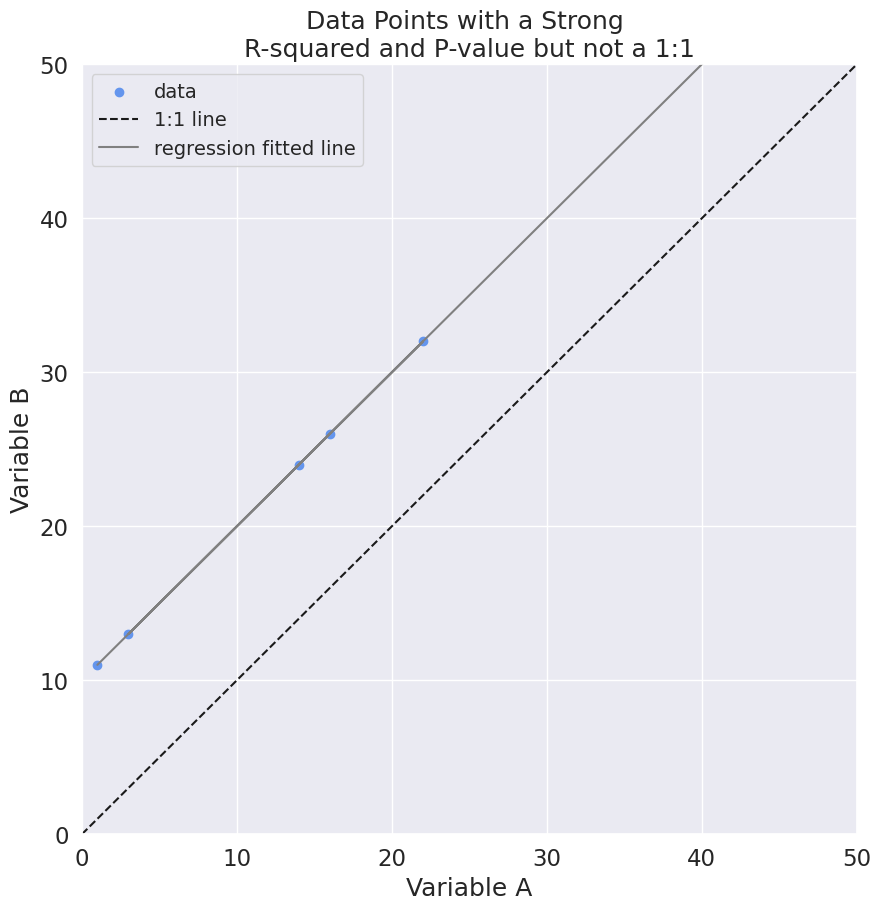

In [7]:
x = np.array([1, 22, 3, 14, 16, 45, 45])
y = np.array([item+10 for item in x])

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(x, y, c='cornflowerblue', label="data")
ax.plot((0, 1), (0, 1), transform=ax.transAxes,
        ls='--', c='k', label="1:1 line")

ax.plot(x, intercept + slope*x, 'grey', label='regression fitted line')
ax.set(xlim=[0, 50], ylim=[0, 50])
ax.set(xlabel="Variable A",
       ylabel="Variable B",
       title="Data Points with a Strong \nR-squared and P-value but not a 1:1")

plt.legend(fontsize=14)

print("slope:", slope,
      "\nintercept:", intercept,
      "\nr squared:", r_value**2,
      "\np-value:", p_value,
      "\nst_error", std_err,
      "\nRMSE", sqrt(std_err))

slope: 1.0 
intercept: -5.0 
r squared: 1.0 
p-value: 1.9206748078018256e-50 
st_error 0.0 
RMSE 0.0


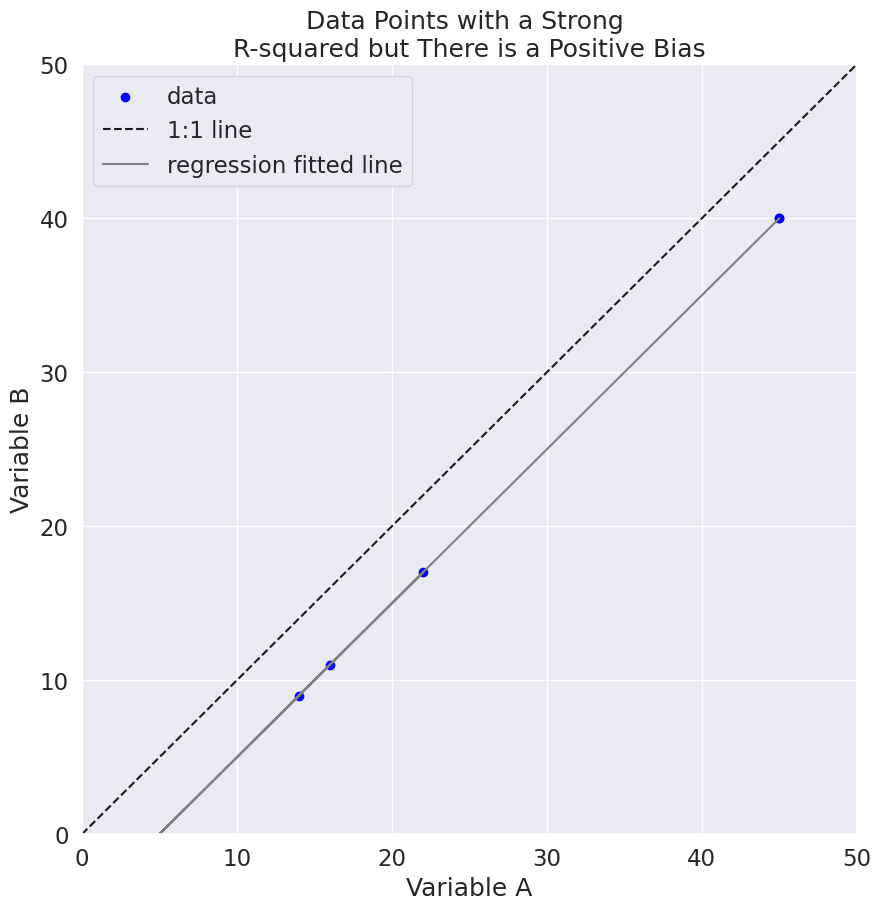

In [8]:
x = np.array([1, 22, 3, 14, 16, 45, 45])
y = np.array([item-5 for item in x])

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)


fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(x, y, c='blue', label="data")
ax.plot((0, 1), (0, 1), transform=ax.transAxes,
        ls='--', c='k', label="1:1 line")

ax.plot(x, intercept + slope*x, 'grey', label='regression fitted line')

ax.set(xlim=[0, 50], ylim=[0, 50])
ax.set(xlabel="Variable A",
       ylabel="Variable B",
       title="Data Points with a Strong \nR-squared but There is a Positive Bias")
plt.legend()

print("slope:", slope,
      "\nintercept:", intercept,
      "\nr squared:", r_value**2,
      "\np-value:", p_value,
      "\nst_error", std_err,
      "\nRMSE", sqrt(std_err))


/tmp/ipykernel_3987/887206249.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "grey" (-> color=(0.5019607843137255, 0.5019607843137255, 0.5019607843137255, 1.0)). The keyword argument will take precedence.
  ax.plot(x, intercept + slope*x, 'grey', label='regression fitted line',


slope: 1.0 
intercept: -5.0 
r squared: 1.0 
p-value: 1.9206748078018256e-50 
st_error 0.0 
RMSE 0.0


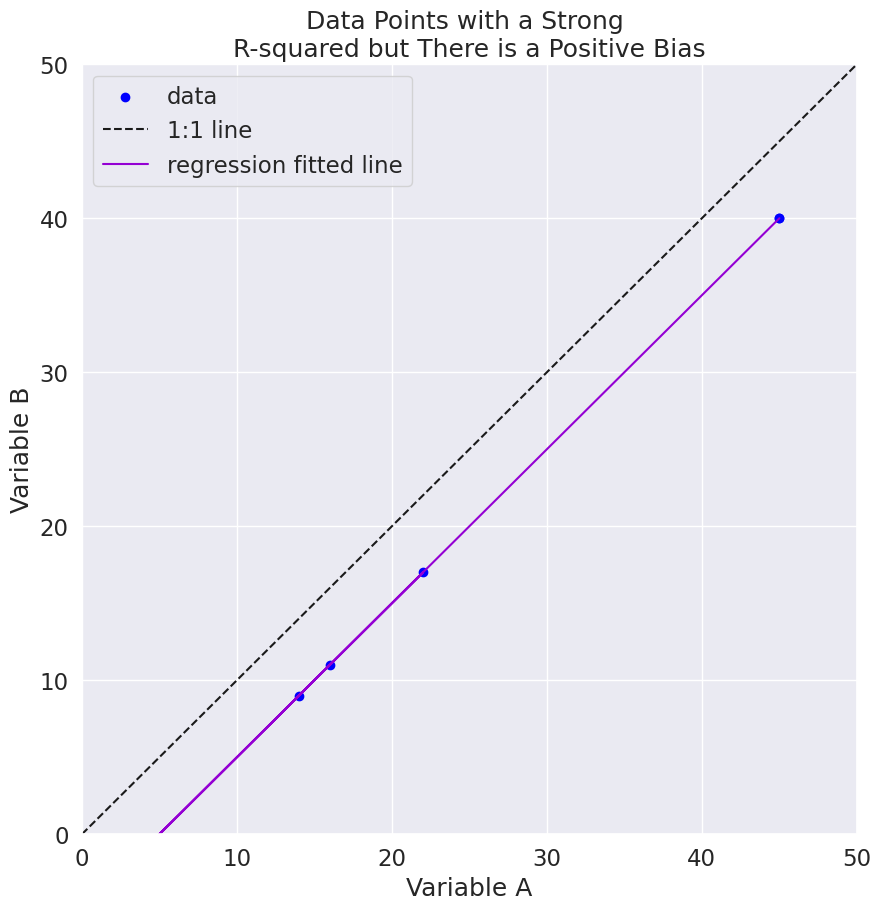

In [9]:
x = np.array([1, 22, 3, 14, 16, 45, 45])
y = np.array([item-5 for item in x])

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(x, y, c='blue', label="data")
ax.plot((0, 1), (0, 1), transform=ax.transAxes,
        ls='--', c='k', label="1:1 line")

ax.plot(x, intercept + slope*x, 'grey', label='regression fitted line',
        color="darkviolet")
ax.set(xlim=[0, 50], ylim=[0, 50])

ax.set(xlabel="Variable A",
       ylabel="Variable B",
       title="Data Points with a Strong \nR-squared but There is a Positive Bias")

plt.legend()

print("slope:", slope,
      "\nintercept:", intercept,
      "\nr squared:", r_value**2,
      "\np-value:", p_value,
      "\nst_error", std_err,
      "\nRMSE", sqrt(std_err))

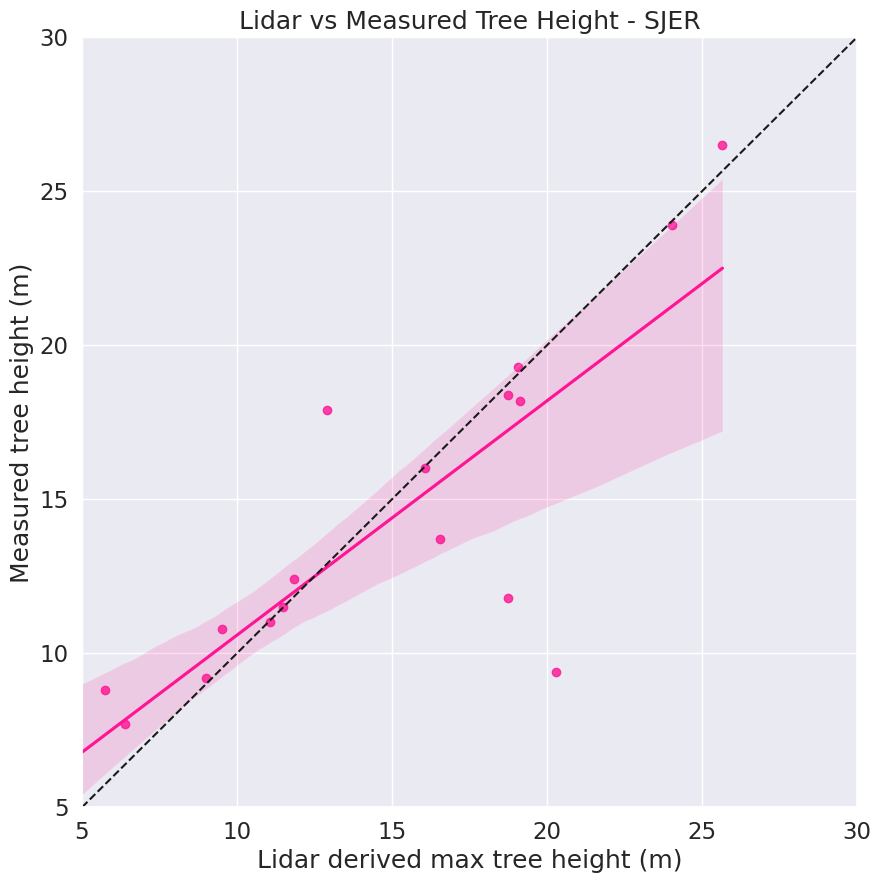

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))

ax = sns.regplot(x='lidar_max', y='insitu_maxht', data=sjer_final_height_df,
                 color="deeppink")

ax.set(xlim=[5, 30], ylim=[5, 30])
ax.plot((0, 1), (0, 1), transform=ax.transAxes, ls='--', c='k')

ax.set(xlabel="Lidar derived max tree height (m)",
       ylabel="Measured tree height (m)",
       title="Lidar vs Measured Tree Height - SJER")

plt.show()

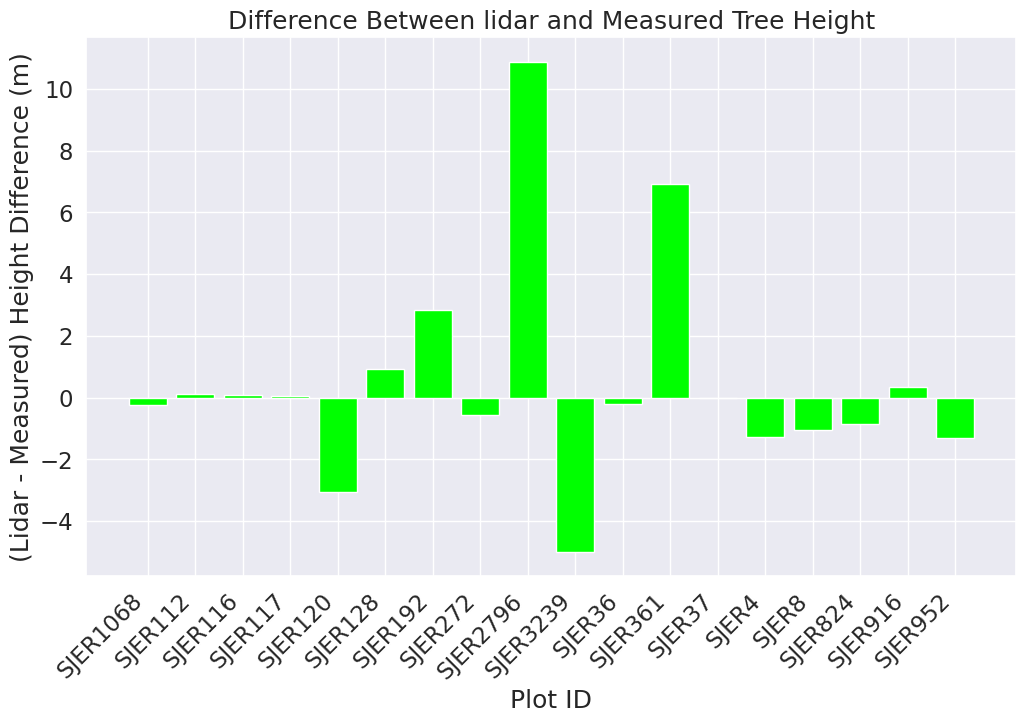

In [ ]:
sjer_final_height["lidar_measured"] = sjer_final_height["lidar_max"] - \
    sjer_final_height["insitu_maxht"]

fig, ax = plt.subplots(figsize=(12, 7))

ax.bar(sjer_final_height['plotid'],
       sjer_final_height['lidar_measured'],
       color="lime")

ax.set(xlabel='Plot ID',
       ylabel='(Lidar - Measured) Height Difference (m)',
       title='Difference Between lidar and Measured Tree Height')

plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()